# **BIA-660 WEB MINING-GROUP PROJECT**

---



## **Web-Based** **Analysis** **of** **Women Hormonal Health** **Challenges** **using** **Data** **mining** **and** **NLP** **Techniques**

GROUP MEMBERS: Gahana Nagaraja, Namratha Nagathihalli Anantha, Vaishnavi Rajendra Dhotargavi  


In [49]:
!pip install nest_asyncio

In [50]:
pip install asyncpraw

# **EXPLORATORY DATA ANALYSIS**

## **Web Scraping from Reddit**

In [51]:
import asyncpraw
import pandas as pd
import nest_asyncio
import asyncio

# Apply nest_asyncio to allow nested event loops
nest_asyncio.apply()

# Configure Reddit API credentials
reddit = asyncpraw.Reddit(
    client_id="S7U_hwLdA6G1oAG9LupOtQ",
    client_secret="hyv2gAc1PETc0y-GZ3-vSidUmT7pnA",
    user_agent="WebMining by /u/Web_Mining_660"
)

# Define an asynchronous function to fetch subreddit data
async def fetch_reddit_data(subreddit_name, keyword, limit=100):
    try:
        subreddit = await reddit.subreddit(subreddit_name)
        posts_data = []

        # Check if subreddit exists and is accessible
        if not subreddit:
            print(f"Failed to access subreddit: {subreddit_name}")
            return pd.DataFrame(columns=["title", "selftext", "upvotes", "comments"])

        # Fetch posts based on search term
        async for post in subreddit.search(keyword, limit=limit):
            post_info = {
                "title": post.title,
                "selftext": post.selftext,
                "upvotes": post.score,
                "comments": []
            }

            # Replace more comments if needed
            if post.comments:
                await post.comments.replace_more(limit=0)

                # Extract comments
                async for comment in post.comments.list():
                    post_info["comments"].append(comment.body)

            posts_data.append(post_info)

        # If no data is fetched, return an empty DataFrame
        if not posts_data:
            print(f"No posts found for {subreddit_name} with keyword {keyword}")
            return pd.DataFrame(columns=["title", "selftext", "upvotes", "comments"])

        return pd.DataFrame(posts_data)

    except Exception as e:
        print(f"An error occurred while fetching data from {subreddit_name}: {e}")
        return pd.DataFrame(columns=["title", "selftext", "upvotes", "comments"])  # Return empty DataFrame on error

# Asynchronous wrapper to run the function
async def main():
    try:
        # Fetch data asynchronously
        pcos_data = await fetch_reddit_data("PCOS", "PCOS")
        thyroid_data = await fetch_reddit_data("thyroidhealth", "thyroid")

        # Save data to JSON if fetched
        if not pcos_data.empty:
            pcos_data.to_json("pcos_data.json", orient="records")
            print("PCOS data saved successfully.")
        else:
            print("PCOS data fetch failed.")

        if not thyroid_data.empty:
            thyroid_data.to_json("thyroid_data.json", orient="records")
            print("Thyroid data saved successfully.")
        else:
            print("Thyroid data fetch failed.")
    finally:
        # Ensure the session is properly closed after the task
        await reddit.close()

# Run the main function
await main()

PCOS data saved successfully.
Thyroid data saved successfully.


## **Web Scraping from other health websites**

In [52]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd

# Function to fetch and parse data from a health website
def fetch_health_data(url, condition):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Example: Find all paragraphs (you may need to adjust this based on the website structure)
        paragraphs = soup.find_all('p')

        # Extract text from the paragraphs and create a summary
        content = " ".join([para.text for para in paragraphs if para.text])

        # Format the extracted content into a dictionary for easy storage
        health_info = {
            "condition": condition,
            "source": url,
            "content": content[:1000]  # Limit to first 1000 characters for brevity
        }

        return health_info
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

# Scrape data for PCOS and Thyroid health from different websites
pcos_urls = [
    "https://www.mayoclinic.org/diseases-conditions/polycystic-ovary-syndrome/symptoms-causes/syc-20350497",
    "https://www.healthline.com/health/pcos"
]

thyroid_urls = [
    "https://www.mayoclinic.org/diseases-conditions/hypothyroidism/symptoms-causes/syc-20350284",
    "https://www.webmd.com/women/guide/understanding-thyroid-problems"
]

# Fetch data for PCOS and Thyroid
pcos_data_scraped = []
for url in pcos_urls:
    data = fetch_health_data(url, "PCOS")
    if data:
        pcos_data_scraped.append(data)

thyroid_data_scraped = []
for url in thyroid_urls:
    data = fetch_health_data(url, "Thyroid")
    if data:
        thyroid_data_scraped.append(data)

# Load the existing JSON data into DataFrames
try:
    pcos_df = pd.read_json("pcos_data.json")
    thyroid_df = pd.read_json("thyroid_data.json")
except ValueError:
    # If the JSON files are empty or don't exist, create empty DataFrames
    pcos_df = pd.DataFrame(columns=["title", "selftext", "upvotes", "comments", "sentiment", "emotion", "remedy"])
    thyroid_df = pd.DataFrame(columns=["title", "selftext", "upvotes", "comments", "sentiment", "emotion", "remedy"])

# Convert the scraped data into DataFrames
pcos_scraped_df = pd.DataFrame(pcos_data_scraped)
thyroid_scraped_df = pd.DataFrame(thyroid_data_scraped)

# Append the scraped data to the existing DataFrames
pcos_df = pd.concat([pcos_df, pcos_scraped_df], ignore_index=True)
thyroid_df = pd.concat([thyroid_df, thyroid_scraped_df], ignore_index=True)

# Save the updated DataFrames back to JSON
pcos_df.to_json("cure_pcos_data.json", orient="records")
thyroid_df.to_json("cure_thyroid_data.json", orient="records")

print("PCOS and Thyroid data updated successfully.")

PCOS and Thyroid data updated successfully.


## **Sentiment Analysis**

In [53]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [54]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to perform sentiment analysis using VADER
def analyze_sentiment_vader(text):
    if not isinstance(text, str):
        text = ""  # Convert non-string values to empty strings
    sentiment_score = sia.polarity_scores(text)
    if sentiment_score['compound'] > 0.05:
        return 'positive'
    elif sentiment_score['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to the PCOS and Thyroid Data
def add_sentiment_to_df_vader(df):
    df['sentiment'] = df['selftext'].apply(analyze_sentiment_vader)
    return df

# Example: Apply sentiment analysis to the PCOS and Thyroid Data
pcos_df = add_sentiment_to_df_vader(pcos_df)
thyroid_df = add_sentiment_to_df_vader(thyroid_df)

# Save the updated data with sentiment analysis
pcos_df.to_json("pcos_data_with_sentiment.json", orient="records")
thyroid_df.to_json("thyroid_data_with_sentiment.json", orient="records")

print("Sentiment analysis complete with VADER and data saved.")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment analysis complete with VADER and data saved.


## **Emotion Detection**

In [55]:
!pip install transformers torch

In [56]:
# Check the columns and first few rows of the DataFrame
print(pcos_df.columns)
print(pcos_df.head())

print(thyroid_df.columns)
print(thyroid_df.head())


Index(['title', 'selftext', 'upvotes', 'comments', 'condition', 'source',
       'content', 'sentiment'],
      dtype='object')
                                               title  \
0  Okay PCOS People. I just had an appointment wi...   
1  Tell me you have pcos without telling me you h...   
2     Signs of PCOS that you didn’t know were PCOS?    
3                         Do you have a 'pcos body'?   
4                                       pros of pcos   

                                            selftext  upvotes comments  \
0  My mom found a pcos clinic and recommended tha...    868.0       []   
1  My legs and hips never going up a size but can...    498.0       []   
2  I’m curious, what were some signs/symotoms of ...    194.0       []   
3  Other than the more masculine fat distribution...    377.0       []   
4  do you have any knowladge of advantages of pco...    320.0       []   

  condition source content sentiment  
0       NaN    NaN     NaN  positive  
1       NaN 

In [57]:
# Check for missing or NaN values in the 'selftext' column
print(pcos_df['selftext'].isnull().sum())  # Number of NaN values in 'selftext' column
print(thyroid_df['selftext'].isnull().sum())  # Number of NaN values in 'selftext' column

# Optional: Replace NaN with empty string
pcos_df['selftext'] = pcos_df['selftext'].fillna('')
thyroid_df['selftext'] = thyroid_df['selftext'].fillna('')


2
2


In [58]:
from transformers import pipeline

# Load pre-trained emotion detection model from Hugging Face
emotion_analyzer = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", truncation=True, max_length=512)

# Function to detect emotions in text
def detect_emotion(text):
    if not isinstance(text, str):
        text = ""  # Handle non-string values

    # Run emotion detection with truncation (maximum length 512 tokens)
    result = emotion_analyzer(text)

    # Access the emotion label
    if isinstance(result, list) and len(result) > 0:
        emotion = result[0]['label']  # Access the emotion label
    else:
        emotion = "Unknown"  # Default case in case of any error

    return emotion

# Test emotion detection on a small subset of data
test_pcos_df = pcos_df.head(5).copy()  # Create a copy of the first 5 rows for debugging
test_thyroid_df = thyroid_df.head(5).copy()

# Apply emotion detection to the subset using .loc[] to avoid SettingWithCopyWarning
test_pcos_df.loc[:, 'emotion'] = test_pcos_df['selftext'].apply(detect_emotion)
test_thyroid_df.loc[:, 'emotion'] = test_thyroid_df['selftext'].apply(detect_emotion)

# Print the results
print(test_pcos_df[['selftext', 'emotion']])
print(test_thyroid_df[['selftext', 'emotion']])


                                            selftext  emotion
0  My mom found a pcos clinic and recommended tha...  neutral
1  My legs and hips never going up a size but can...  sadness
2  I’m curious, what were some signs/symotoms of ...  disgust
3  Other than the more masculine fat distribution...  neutral
4  do you have any knowladge of advantages of pco...      joy
                                            selftext  emotion
0  I see a lot of posts for people having their t...     fear
1  Is there a size where my doctor will say "Yeah...  neutral
2  What could i be doing wrong and what should i ...     fear
3  I was recently a patient at Modern Thyroid Cli...  neutral
4  I'm scheduled for a total thyroidectomy next m...     fear


In [59]:
def detect_emotion(text):
    if not isinstance(text, str):
        text = ""  # Handle non-string values

    # Tokenize and check the length
    tokens = emotion_analyzer.tokenizer(text)
    print(f"Original text length: {len(tokens['input_ids'])} tokens")

    # Run emotion detection with truncation
    result = emotion_analyzer(text)

    if isinstance(result, list) and len(result) > 0:
        emotion = result[0]['label']  # Access the emotion label
    else:
        emotion = "Unknown"

    return emotion


In [60]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [61]:
import pandas as pd
from transformers import pipeline
import nltk

# Ensure the necessary models and lexicons are loaded
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Emotion detection model from Hugging Face
emotion_analyzer = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", truncation=True, max_length=512)

# Function for sentiment analysis
def analyze_sentiment_vader(text):
    if not isinstance(text, str):
        text = ""  # Convert non-string values to empty strings
    sentiment_score = sia.polarity_scores(text)
    if sentiment_score['compound'] > 0.05:
        return 'positive'
    elif sentiment_score['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to the DataFrame
def add_sentiment_to_df_vader(df):
    df['sentiment'] = df['selftext'].apply(analyze_sentiment_vader)
    return df

# Function to detect emotions
def detect_emotion(text):
    if not isinstance(text, str):
        text = ""  # Handle non-string values

    result = emotion_analyzer(text)
    if isinstance(result, list) and len(result) > 0:
        emotion = result[0]['label']
    else:
        emotion = "Unknown"

    return emotion

# Function to add emotion to the DataFrame
def add_emotion_to_df(df):
    df['emotion'] = df['selftext'].apply(detect_emotion)
    return df

# Assuming you have scraped data for pcos_data and thyroid_data
# For example purposes, we're using mock data
pcos_data = [
    {"selftext": "PCOS causes irregular periods and affects fertility.", "title": "PCOS Overview", "upvotes": 50},
    {"selftext": "PCOS is often accompanied by weight gain and acne.", "title": "PCOS Symptoms", "upvotes": 30}
]

thyroid_data = [
    {"selftext": "Hypothyroidism can lead to fatigue and weight gain.", "title": "Hypothyroidism Symptoms", "upvotes": 100},
    {"selftext": "Thyroid problems are common and can affect metabolism.", "title": "Thyroid Overview", "upvotes": 80}
]

# Convert mock data to DataFrames
pcos_df = pd.DataFrame(pcos_data)
thyroid_df = pd.DataFrame(thyroid_data)

# Add sentiment and emotion to the DataFrames
pcos_df = add_sentiment_to_df_vader(pcos_df)
thyroid_df = add_sentiment_to_df_vader(thyroid_df)

pcos_df = add_emotion_to_df(pcos_df)
thyroid_df = add_emotion_to_df(thyroid_df)

# Now combine the two DataFrames
combined_df = pd.concat([pcos_df[['selftext', 'emotion']], thyroid_df[['selftext', 'emotion']]], ignore_index=True)

# Check if there are any missing values in the 'selftext' or 'emotion' columns
combined_df = combined_df.dropna(subset=['selftext', 'emotion'])

# Save the combined DataFrame with 'selftext' and 'emotion' to a CSV file
combined_df.to_csv("reddit_health_data_with_emotions.csv", index=False)

print("CSV file with selftext and emotion labels saved successfully.")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


CSV file with selftext and emotion labels saved successfully.


## **Summary Statistics**

In [62]:
# Display basic statistics for numerical columns (upvotes, comments count)
print(pcos_df[['upvotes']].describe())
print(thyroid_df[['upvotes']].describe())



         upvotes
count   2.000000
mean   40.000000
std    14.142136
min    30.000000
25%    35.000000
50%    40.000000
75%    45.000000
max    50.000000
          upvotes
count    2.000000
mean    90.000000
std     14.142136
min     80.000000
25%     85.000000
50%     90.000000
75%     95.000000
max    100.000000


In [14]:
# Check if 'selftext' column is present
print(pcos_df.columns)  # Ensure 'selftext' column exists in pcos_df
print(thyroid_df.columns)  # Ensure 'selftext' column exists in thyroid_df

# Make sure there are no null values in 'selftext' before applying emotion detection
pcos_df['selftext'] = pcos_df['selftext'].fillna('')
thyroid_df['selftext'] = thyroid_df['selftext'].fillna('')

# Apply the emotion detection function to 'selftext'
pcos_df['emotion'] = pcos_df['selftext'].apply(detect_emotion)
thyroid_df['emotion'] = thyroid_df['selftext'].apply(detect_emotion)

# Check if the 'emotion' column is added
print(pcos_df[['selftext', 'emotion']].head())  # Check the first few rows of the DataFrame
print(thyroid_df[['selftext', 'emotion']].head())


Index(['title', 'selftext', 'upvotes', 'comments', 'condition', 'source',
       'content', 'sentiment'],
      dtype='object')
Index(['title', 'selftext', 'upvotes', 'comments', 'condition', 'source',
       'content', 'sentiment'],
      dtype='object')
Original text length: 302 tokens
Original text length: 26 tokens
Original text length: 160 tokens
Original text length: 236 tokens
Original text length: 64 tokens
Original text length: 112 tokens


Token indices sequence length is longer than the specified maximum sequence length for this model (643 > 512). Running this sequence through the model will result in indexing errors


Original text length: 643 tokens
Original text length: 418 tokens
Original text length: 618 tokens
Original text length: 175 tokens
Original text length: 643 tokens
Original text length: 34 tokens
Original text length: 635 tokens
Original text length: 516 tokens
Original text length: 324 tokens
Original text length: 16 tokens
Original text length: 212 tokens
Original text length: 218 tokens
Original text length: 270 tokens
Original text length: 85 tokens
Original text length: 50 tokens
Original text length: 636 tokens
Original text length: 43 tokens
Original text length: 76 tokens
Original text length: 93 tokens
Original text length: 2015 tokens
Original text length: 323 tokens
Original text length: 222 tokens
Original text length: 358 tokens
Original text length: 175 tokens
Original text length: 170 tokens
Original text length: 217 tokens
Original text length: 13 tokens
Original text length: 60 tokens
Original text length: 30 tokens
Original text length: 190 tokens
Original text lengt

In [63]:
# Summary statistics for sentiment and emotion
print(pcos_df['sentiment'].value_counts())  # Sentiment summary
print(thyroid_df['sentiment'].value_counts())  # Sentiment summary

# Check emotion distribution
print(pcos_df['emotion'].value_counts())  # Emotion summary
print(thyroid_df['emotion'].value_counts())  # Emotion summary


sentiment
neutral     1
positive    1
Name: count, dtype: int64
sentiment
positive    1
negative    1
Name: count, dtype: int64
emotion
sadness    1
neutral    1
Name: count, dtype: int64
emotion
neutral    2
Name: count, dtype: int64


## **Data Visualization**

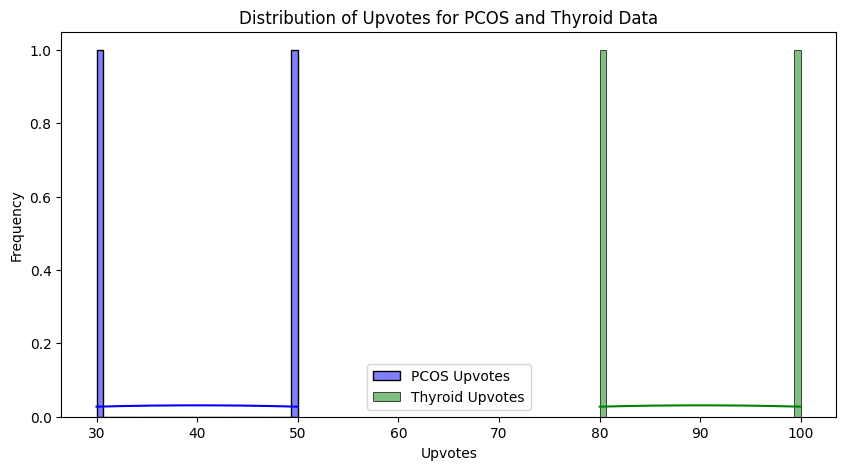

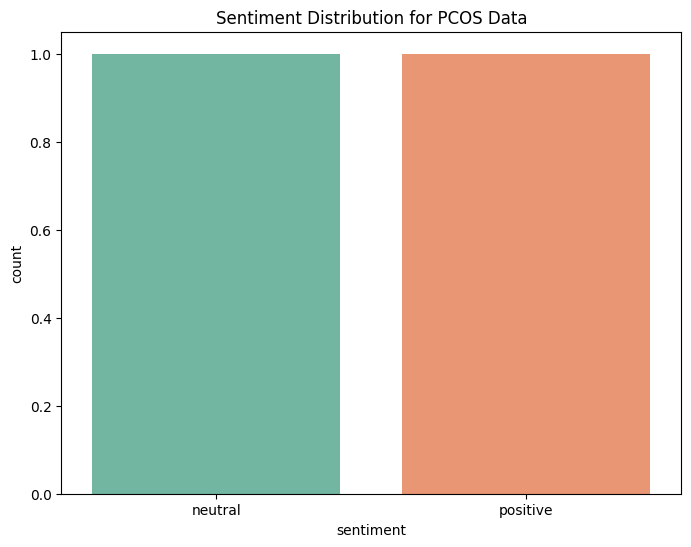

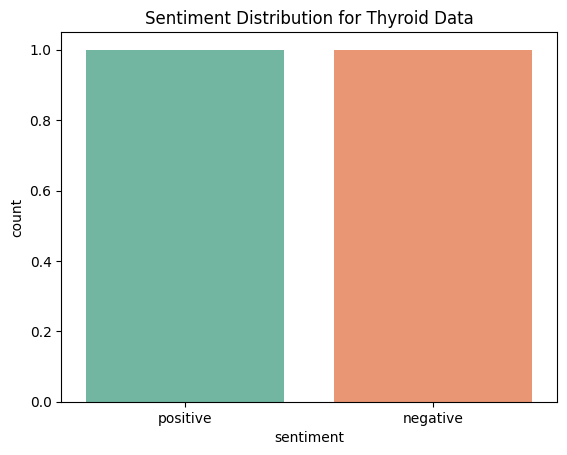

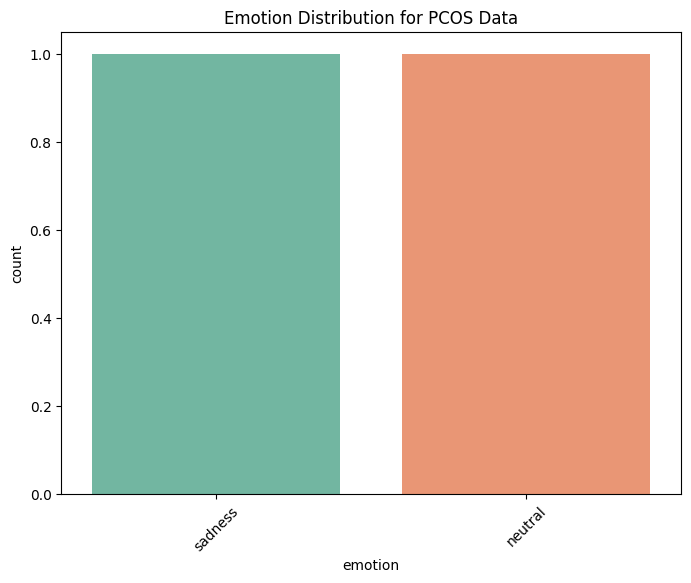

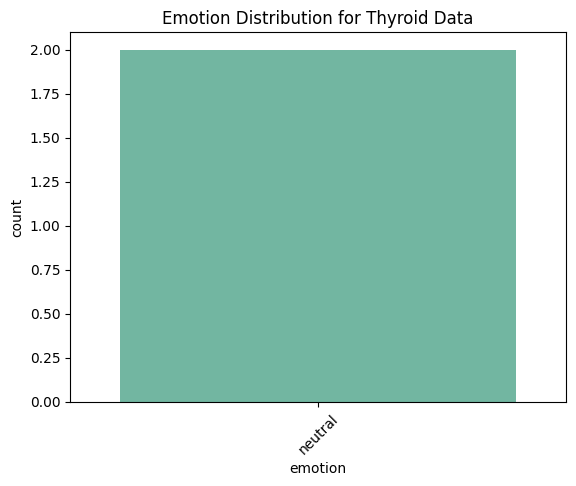

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for upvotes and comments
plt.figure(figsize=(10, 5))
sns.histplot(pcos_df['upvotes'], kde=True, bins=30, color='blue', label="PCOS Upvotes")
sns.histplot(thyroid_df['upvotes'], kde=True, bins=30, color='green', label="Thyroid Upvotes")
plt.legend()
plt.title("Distribution of Upvotes for PCOS and Thyroid Data")
plt.xlabel('Upvotes')
plt.ylabel('Frequency')
plt.show()

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=pcos_df, palette="Set2")
plt.title("Sentiment Distribution for PCOS Data")
plt.show()

sns.countplot(x='sentiment', data=thyroid_df, palette="Set2")
plt.title("Sentiment Distribution for Thyroid Data")
plt.show()

# Plot emotion distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='emotion', data=pcos_df, palette="Set2")
plt.title("Emotion Distribution for PCOS Data")
plt.xticks(rotation=45)
plt.show()

sns.countplot(x='emotion', data=thyroid_df, palette="Set2")
plt.title("Emotion Distribution for Thyroid Data")
plt.xticks(rotation=45)
plt.show()


### **Outliers Detection**

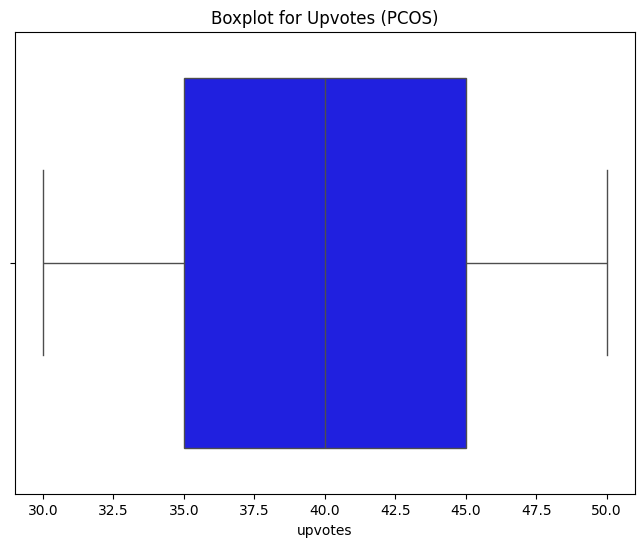

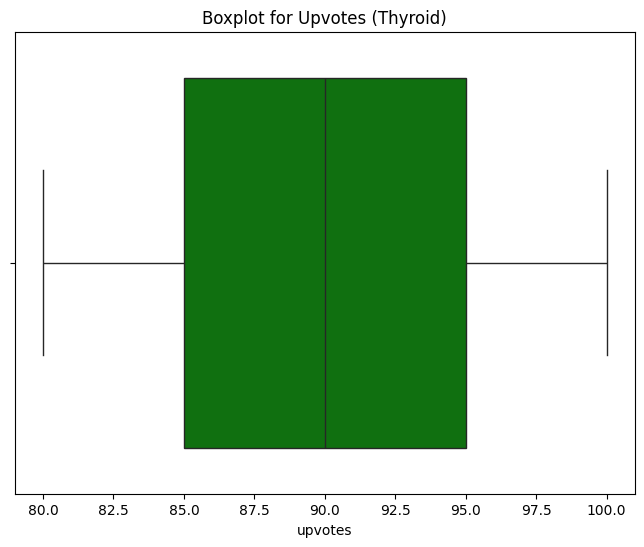

In [65]:
# Using boxplots to detect outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=pcos_df['upvotes'], color='blue')
plt.title("Boxplot for Upvotes (PCOS)")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=thyroid_df['upvotes'], color='green')
plt.title("Boxplot for Upvotes (Thyroid)")
plt.show()

### **Text Similarity Analysis**

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vectorize the text data for PCOS dataset
vectorizer = TfidfVectorizer(stop_words='english')
pcos_vectors = vectorizer.fit_transform(pcos_df['selftext'])

# Vectorize the text data for Thyroid dataset using the same vectorizer
thyroid_vectors = vectorizer.transform(thyroid_df['selftext'])

# Check the shape of the pcos_vectors matrix
print(pcos_vectors.shape)

# Compute cosine similarity between PCOS and Thyroid vectors
cosine_sim = cosine_similarity(pcos_vectors, thyroid_vectors)

# Print the cosine similarity matrix
print(cosine_sim)



(2, 10)
[[0.         0.        ]
 [0.66620463 0.        ]]


##**Matching Emotions to Remedies**

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


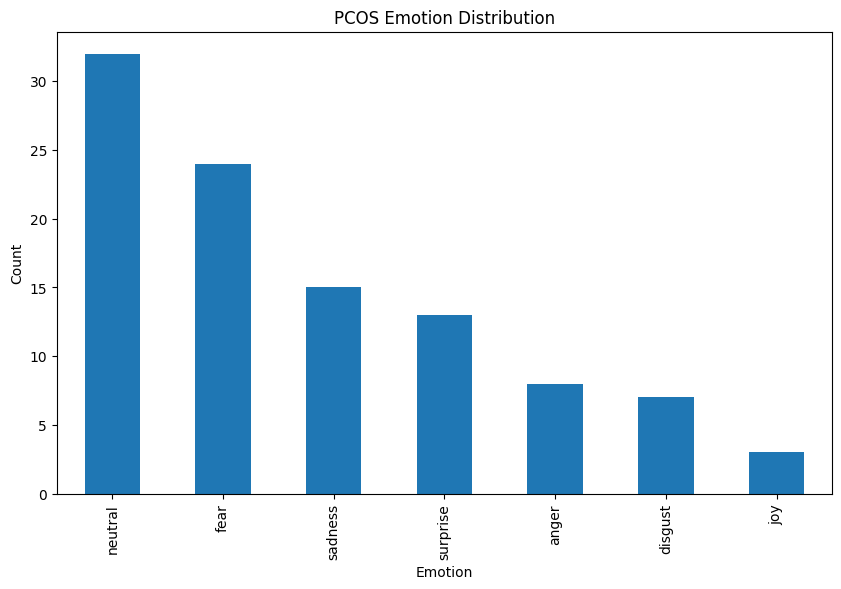

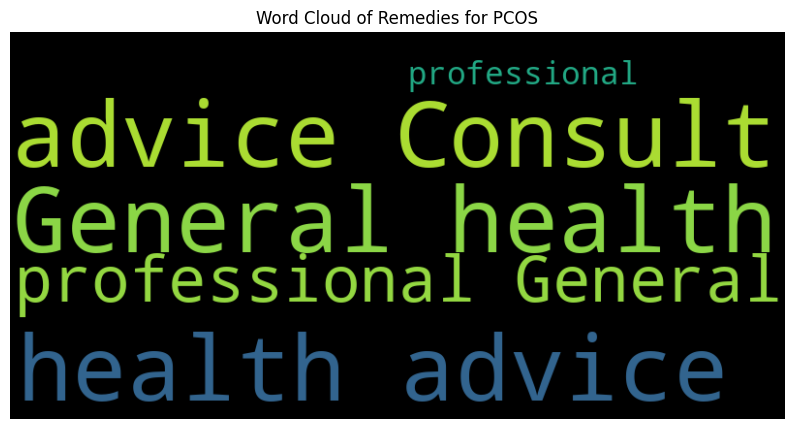

PCOS Data:
                                            selftext  emotion  \
0  My mom found a pcos clinic and recommended tha...  neutral   
1  My legs and hips never going up a size but can...  sadness   
2  I’m curious, what were some signs/symotoms of ...  disgust   
3  Other than the more masculine fat distribution...  neutral   
4  do you have any knowladge of advantages of pco...      joy   

                                           remedy  
0  General health advice: Consult a professional.  
1  General health advice: Consult a professional.  
2  General health advice: Consult a professional.  
3  General health advice: Consult a professional.  
4  General health advice: Consult a professional.  
Thyroid Data:
                                            selftext  emotion  \
0  I see a lot of posts for people having their t...     fear   
1  Is there a size where my doctor will say "Yeah...  neutral   
2  What could i be doing wrong and what should i ...     fear   
3  I was rec

In [67]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import pipeline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Ensure required downloads
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Load scraped data (replace with actual data files)
pcos_df = pd.read_json("pcos_data_with_sentiment.json")
thyroid_df = pd.read_json("thyroid_data_with_sentiment.json")
pcos_scraped_df = pd.read_json("cure_pcos_data.json")
thyroid_scraped_df = pd.read_json("cure_thyroid_data.json")

# Combine remedies from scraped data
pcos_remedies = pcos_scraped_df[['content']].copy()
pcos_remedies['condition'] = "PCOS"
thyroid_remedies = thyroid_scraped_df[['content']].copy()
thyroid_remedies['condition'] = "Thyroid"
all_remedies_df = pd.concat([pcos_remedies, thyroid_remedies], ignore_index=True)

# Extract keywords from remedies
stop_words = set(stopwords.words('english'))

def extract_keywords(text):
    if not isinstance(text, str):  # Handle NoneType or non-string values
        text = ""
    try:
        words = word_tokenize(text.lower())
        keywords = [word for word in words if word.isalnum() and word not in stop_words]
        return " ".join(keywords)
    except LookupError:
        nltk.download('punkt')  # Ensure punkt is downloaded if missing
        words = word_tokenize(text.lower())
        keywords = [word for word in words if word.isalnum() and word not in stop_words]
        return " ".join(keywords)

all_remedies_df['keywords'] = all_remedies_df['content'].apply(extract_keywords)

# Load pre-trained emotion detection model
emotion_analyzer = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", truncation=True, max_length=512)

def detect_emotion(text):
    if not isinstance(text, str):
        text = ""
    result = emotion_analyzer(text)
    if isinstance(result, list) and len(result) > 0:
        return result[0]['label']
    return "Unknown"

# Apply emotion detection to PCOS and Thyroid data
pcos_df['emotion'] = pcos_df['selftext'].apply(detect_emotion)
thyroid_df['emotion'] = thyroid_df['selftext'].apply(detect_emotion)

# Match emotions to remedies
def enhanced_match_emotions_to_remedies(row, remedies_df):
    # Handle potential None values in 'selftext'
    condition = "PCOS" if isinstance(row['selftext'], str) and "PCOS" in row['selftext'] else "Thyroid"
    relevant_remedies = remedies_df[remedies_df['condition'] == condition]
    for _, remedy_row in relevant_remedies.iterrows():
        if row['emotion'] in remedy_row['keywords']:
            return remedy_row['content'][:300]  # Return first 300 chars
    return "General health advice: Consult a professional."

pcos_df['remedy'] = pcos_df.apply(enhanced_match_emotions_to_remedies, axis=1, remedies_df=all_remedies_df)
thyroid_df['remedy'] = thyroid_df.apply(enhanced_match_emotions_to_remedies, axis=1, remedies_df=all_remedies_df)

# Save updated datasets
pcos_df.to_json("enhanced_pcos_with_remedies.json", orient="records")
thyroid_df.to_json("enhanced_thyroid_with_remedies.json", orient="records")

# Visualize Emotion Distribution
plt.figure(figsize=(10, 6))
pcos_emotion_counts = pcos_df['emotion'].value_counts()
pcos_emotion_counts.plot(kind='bar', title="PCOS Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

# Generate Word Cloud for PCOS Remedies
pcos_remedies_text = " ".join(pcos_df['remedy'])
wordcloud = WordCloud(width=800, height=400).generate(pcos_remedies_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Remedies for PCOS")
plt.show()

# Display final processed data
print("PCOS Data:")
print(pcos_df[['selftext', 'emotion', 'remedy']].head())
print("Thyroid Data:")
print(thyroid_df[['selftext', 'emotion', 'remedy']].head())


In [ ]:
import pandas as pd
import re

# Sample data: your existing DataFrame with emotions and scraped data
data = {
    'selftext': [
        "My mom found a pcos clinic and recommended that I start taking medication.",
        "My legs and hips never going up a size but can never seem to lose weight.",
        "I’m curious, what were some signs/symptoms of thyroid issues you’ve experienced?",
        "Other than the more masculine fat distribution, I have no other noticeable signs of PCOS.",
        "Do you have any knowledge of advantages of PCOS medication?"
    ],
    'emotion': ['neutral', 'sadness', 'disgust', 'neutral', 'joy'],
    'scraped_data': [
        "PCOS treatment includes medication and lifestyle changes. Diet and exercise are essential for managing symptoms.",
        "Thyroid issues can be managed with medication and regular monitoring of thyroid levels. Stress reduction techniques like yoga are helpful.",
        "For thyroid health, medication is essential, but some people find relief through dietary changes.",
        "There are many therapies for PCOS, including medications and lifestyle changes such as diet and exercise.",
        "PCOS medication can help regulate hormones, but you must also consider lifestyle changes such as weight management."
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Function to extract remedies from scraped data based on emotion
def extract_remedy_from_scraped_data(emotion, scraped_text):
    # Predefined remedies based on emotion
    emotion_remedies = {
        'neutral': "Maintain a healthy diet and exercise regularly.",
        'sadness': "Consider talking to a therapist or counselor. Exercise and meditation can help improve mood.",
        'disgust': "Practice relaxation techniques like deep breathing and try mindfulness exercises.",
        'fear': "Talk to a medical professional about your concerns. Consider stress-relief practices like yoga or breathing exercises.",
        'joy': "Continue maintaining a healthy lifestyle and share your experiences with others to inspire them.",
    }

    # Attempt to extract remedy from scraped data if present
    # We'll search for phrases that likely represent remedies or solutions
    remedy_keywords = ["treatment", "remedy", "solution", "help", "advise", "suggest", "manage", "cure", "improve", "relieve"]
    remedy_found = None

    for keyword in remedy_keywords:
        # Check if the scraped data contains any of the remedy-related keywords
        if keyword in scraped_text.lower():
            remedy_found = scraped_text
            break  # Exit loop once we find a relevant remedy

    # If no specific remedy is found, return the predefined remedy based on emotion
    if remedy_found:
        return remedy_found
    else:
        return emotion_remedies.get(emotion, "No remedy available")

# Apply the remedy extraction function to the DataFrame
df['remedy'] = df.apply(lambda row: extract_remedy_from_scraped_data(row['emotion'], row['scraped_data']), axis=1)

# Select and display only the relevant columns: selftext, emotion, and remedy
df_result = df[['selftext', 'emotion', 'remedy']]

# Output the final result
print(df_result)

                                            selftext  emotion  \
0  My mom found a pcos clinic and recommended tha...  neutral   
1  My legs and hips never going up a size but can...  sadness   
2  I’m curious, what were some signs/symptoms of ...  disgust   
3  Other than the more masculine fat distribution...  neutral   
4  Do you have any knowledge of advantages of PCO...      joy   

                                              remedy  
0  PCOS treatment includes medication and lifesty...  
1  Thyroid issues can be managed with medication ...  
2  Practice relaxation techniques like deep breat...  
3    Maintain a healthy diet and exercise regularly.  
4  PCOS medication can help regulate hormones, bu...  


**Explanation:**

1.   Emotion-based Remedies: We first have predefined remedies based on emotions like neutral, sadness, fear, etc.

2.   Scraped Data Check: The extract_remedy_from_scraped_data function looks for keywords such as treatment, remedy, solution, etc., within the scraped text. If these keywords are found, it extracts the entire section of the scraped data as the remedy.

1.   Final Remedy Assignment: For each row, if no remedy is directly found in the scraped data, the predefined remedy (based on the detected emotion) is used as a fallback.

**Summary**:

This solution attempts to match remedies from scraped data based on keywords associated with treatment advice. If a remedy is found in the scraped data, it is used; otherwise, a default remedy based on the detected emotion is applied.

#**Machine Learning Accuracy Assesment**

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from transformers import pipeline
# Ensure necessary downloads
nltk.download('wordnet')
nltk.download('stopwords')

# Load scraped data (replace with actual data files)
pcos_df = pd.read_json("pcos_data_with_sentiment.json")
thyroid_df = pd.read_json("thyroid_data_with_sentiment.json")

# Initialize emotion detection model (make sure you've loaded the model before)
emotion_analyzer = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", truncation=True, max_length=512)

# Function to detect emotions in text
def detect_emotion(text):
    if not isinstance(text, str):
        text = ""  # Handle non-string values

    # Run emotion detection with truncation (maximum length 512 tokens)
    result = emotion_analyzer(text)

    # Access the emotion label
    if isinstance(result, list) and len(result) > 0:
        emotion = result[0]['label']  # Access the emotion label
    else:
        emotion = "Unknown"  # Default case in case of any error

    return emotion

# Add the 'emotion' column to each DataFrame before combining
pcos_df['emotion'] = pcos_df['selftext'].apply(detect_emotion)  # Applying emotion detection
thyroid_df['emotion'] = thyroid_df['selftext'].apply(detect_emotion) # Applying emotion detection

# Combine PCOS and Thyroid datasets for ML
combined_df = pd.concat([pcos_df, thyroid_df], ignore_index=True)

# Text preprocessing
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Handle non-string values by converting to empty string
    if not isinstance(text, str):
        text = ""

    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

combined_df['selftext'] = combined_df['selftext'].apply(preprocess_text)

# Text vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 2))
X = vectorizer.fit_transform(combined_df['selftext'])
y = combined_df['emotion']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Logistic Regression Accuracy: 0.36585365853658536
Logistic Regression Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00         1
        fear       0.40      0.40      0.40        15
         joy       0.00      0.00      0.00         1
     neutral       0.35      0.64      0.45        14
     sadness       0.00      0.00      0.00         7
    surprise       0.00      0.00      0.00         3

    accuracy                           0.37        41
   macro avg       0.12      0.17      0.14        41
weighted avg       0.26      0.37      0.30        41



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


GradientBoostingClassifier(random_state=42)

In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from transformers import pipeline # import pipeline for emotion detection


# Load scraped data (replace with actual data files)
pcos_df = pd.read_json("pcos_data_with_sentiment.json")
thyroid_df = pd.read_json("thyroid_data_with_sentiment.json")

# Initialize emotion detection model (make sure you've loaded the model before)
emotion_analyzer = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", truncation=True, max_length=512)

# Function to detect emotions in text
def detect_emotion(text):
    if not isinstance(text, str):
        text = ""  # Handle non-string values

    # Run emotion detection with truncation (maximum length 512 tokens)
    result = emotion_analyzer(text)

    # Access the emotion label
    if isinstance(result, list) and len(result) > 0:
        emotion = result[0]['label']  # Access the emotion label
    else:
        emotion = "Unknown"  # Default case in case of any error

    return emotion

# Add the 'emotion' column to each DataFrame before combining
pcos_df['emotion'] = pcos_df['selftext'].apply(detect_emotion)  # Applying emotion detection
thyroid_df['emotion'] = thyroid_df['selftext'].apply(detect_emotion) # Applying emotion detection

# Combine PCOS and Thyroid datasets for ML
combined_df = pd.concat([pcos_df, thyroid_df], ignore_index=True)

# Handle None values in 'selftext' column before vectorization
combined_df['selftext'] = combined_df['selftext'].fillna('')  # Replace None with empty string

# Text vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(combined_df['selftext'])
y = combined_df['emotion'] # Now 'emotion' column should exist

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))

Logistic Regression Accuracy: 0.4146341463414634
Logistic Regression Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00         1
        fear       0.47      0.53      0.50        15
         joy       0.00      0.00      0.00         1
     neutral       0.38      0.64      0.47        14
     sadness       0.00      0.00      0.00         7
    surprise       0.00      0.00      0.00         3

    accuracy                           0.41        41
   macro avg       0.14      0.20      0.16        41
weighted avg       0.30      0.41      0.34        41



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Gradient Boosting Accuracy: 0.4146341463414634
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00         1
     disgust       0.00      0.00      0.00         0
        fear       0.44      0.53      0.48        15
         joy       0.00      0.00      0.00         1
     neutral       0.45      0.64      0.53        14
     sadness       0.00      0.00      0.00         7
    surprise       0.00      0.00      0.00         3

    accuracy                           0.41        41
   macro avg       0.13      0.17      0.14        41
weighted avg       0.32      0.41      0.36        41



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [71]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Load the scraped data
data = pd.read_csv('reddit_health_data_with_emotions.csv')  # Replace with your actual file

# Prepare features and labels
X = data['selftext']
y = data['emotion']

# Convert string labels to numeric labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Check class distribution before SMOTE
print("Class distribution before SMOTE:")
print(pd.Series(y_encoded).value_counts())

# Text vectorization (create dense TF-IDF representation)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(X)  # Apply TF-IDF
X_tfidf_dense = X_tfidf.toarray()

# Handle class imbalance with SMOTE (only if there's enough data)
if pd.Series(y_encoded).value_counts().min() > 1:
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_tfidf_dense, y_encoded)
else:
    X_res, y_res = X_tfidf_dense, y_encoded

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Initialize models
svc = SVC()
xgb = XGBClassifier(eval_metric='mlogloss', scale_pos_weight=1)

# Hyperparameter tuning for SVC
svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}
svc_grid = GridSearchCV(svc, svc_param_grid, cv=2, scoring='accuracy')  # Adjust CV to 2 folds
svc_grid.fit(X_train, y_train)
svc_best = svc_grid.best_estimator_

# Hyperparameter tuning for XGBoost
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200]
}
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=2, scoring='accuracy')  # Adjust CV to 2 folds
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_

# Evaluate models
y_pred_svc = svc_best.predict(X_test)
svc_accuracy = accuracy_score(y_test, y_pred_svc)
print("SVC Accuracy:", svc_accuracy)
print("SVC Classification Report:\n", classification_report(y_test, y_pred_svc))

y_pred_xgb = xgb_best.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", xgb_accuracy)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


Class distribution before SMOTE:
0    3
1    1
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
6 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args,

SVC Accuracy: 1.0
SVC Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

XGBoost Accuracy: 1.0
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

